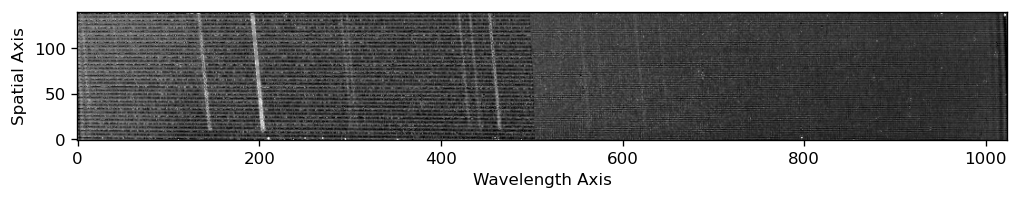

In [52]:
# import packages
from matplotlib import rcParams
rcParams['figure.dpi'] = 120
rcParams["savefig.dpi"] = 200
rcParams['figure.facecolor'] = 'w'

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from lmfit import Model
from lmfit.models import PolynomialModel, QuadraticModel, LinearModel, ConstantModel
from lmfit import minimize, Parameters, fit_report

import os
import warnings
warnings.filterwarnings('ignore')


# path joining version for other paths
notebook_path = os.path.abspath('/Users/RuoyanWang/Documents/LEICESTER/h3p/code/')
filepath = os.path.join(os.path.dirname(notebook_path), '02jun17/spec/')

# count number of fits files in folder
filesize = len([name for name in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, name))])

# load fits data
nirspec7_data = []

start_nirspec7 = 22 # fits index start, min >= 1, max <= n
end_nirspec7 = 112 # fits index end, min >= n, max <= 999

# order36
for i in range(filesize):
    n = i + start_nirspec7
    if n>= start_nirspec7 and n < 10:
        hdu_data = fits.getdata(filepath + 'order36/' + 'jun02s000' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n>= 10 and n < 100:
        hdu_data = fits.getdata(filepath + 'order36/' + 'jun02s00' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n >= 100 and n < end_nirspec7: # fits index ends at 111
        hdu_data = fits.getdata(filepath + 'order36/' + 'jun02s0' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n >= end_nirspec7:
        break
nirspec7_data_array = np.array(nirspec7_data)

# load waverange
waverange = fits.open(filepath + 'order36/' + 'waverange.fits', ignore_missing_end=True)[0].data

# obtain average flat field
average_flat_field = np.mean((nirspec7_data_array[32-start_nirspec7], 
                              nirspec7_data_array[33-start_nirspec7], 
                              nirspec7_data_array[34-start_nirspec7], 
                              nirspec7_data_array[35-start_nirspec7], 
                              nirspec7_data_array[36-start_nirspec7], 
                              nirspec7_data_array[37-start_nirspec7], 
                              nirspec7_data_array[38-start_nirspec7], 
                              nirspec7_data_array[39-start_nirspec7], 
                              nirspec7_data_array[40-start_nirspec7], 
                              nirspec7_data_array[41-start_nirspec7],), axis=0)


# obtain average flat lamp off
average_flat_lamp_off = np.mean((nirspec7_data_array[22-start_nirspec7], 
                                 nirspec7_data_array[23-start_nirspec7], 
                                 nirspec7_data_array[24-start_nirspec7],
                                 nirspec7_data_array[25-start_nirspec7], 
                                 nirspec7_data_array[26-start_nirspec7], 
                                 nirspec7_data_array[27-start_nirspec7], 
                                 nirspec7_data_array[28-start_nirspec7], 
                                 nirspec7_data_array[29-start_nirspec7], 
                                 nirspec7_data_array[30-start_nirspec7], 
                                 nirspec7_data_array[31-start_nirspec7],), axis=0)

# convert observation time (UTC) to seconds 
def fits_header_utc_to_second(fn):
    # fn = frame_number
    if fn >= start_nirspec7 and fn < 10:
        hdu_header = fits.open(filepath + 'jun02s000' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= 10 and fn < 100:
        hdu_header = fits.open(filepath + 'jun02s00' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= 100 and fn < end_nirspec7:
        hdu_header = fits.open(filepath + 'jun02s0' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= end_nirspec7:
        pass
    
    h = float(hdu_header['UTC'].split(':')[0])
    m = float(hdu_header['UTC'].split(':')[1])
    s = float(hdu_header['UTC'].split(':')[2])
    
    seconds = h * 3600 + m * 60 + s
    return seconds

# scale the sky frame using the equation on page 9 of Stallard_et_al_2019
def scale_sky_frame(fn_spec):
    """
    confirmed sky frames: 51, 59, 60, 72, 78, 79, 91, 103
    """
    if fn_spec > 51 and fn_spec < 59:
        fn_sky1 = 51 # frame number of sky1
        fn_sky2 = 59 # frame number of sky2
    elif fn_spec > 60 and fn_spec < 72:
        fn_sky1 = 60
        fn_sky2 = 72
    elif fn_spec > 72 and fn_spec < 78:
        fn_sky1 = 72
        fn_sky2 = 78
    elif fn_spec > 78 and fn_spec < 91:
        fn_sky1 = 79
        fn_sky2 = 91
    elif fn_spec > 91 and fn_spec < 103:
        fn_sky1 = 91
        fn_sky2 = 103

    sky1 = nirspec7_data_array[fn_sky1-start_nirspec7]
    sky2 = nirspec7_data_array[fn_sky2-start_nirspec7]

    t1 = fits_header_utc_to_second(fn_sky1) 
    t2 = fits_header_utc_to_second(fn_sky2)
    td = fits_header_utc_to_second(fn_spec)

    sky_final = sky1 * ((t2 - td) / (t2 - t1)) + sky2 * ((td - t1) / (t2 - t1))
    return sky_final

# define object and sky frame
fn_spec = 65 # frame number of target spectra
sky_total = scale_sky_frame(fn_spec)

# remove sky background: (object - sky_frame)/(average_flat_field - average_flat_lamp_off)
target_spec = nirspec7_data_array[fn_spec-start_nirspec7]
sky_subtracted = (target_spec - sky_total) / (average_flat_field - average_flat_lamp_off)
pixel = np.linspace(0, np.size(sky_subtracted, 1), np.size(sky_subtracted, 1))

# show reduced fits
#plt.figure(figsize=(12,6))
#plt.imshow(sky_subtracted, cmap='gist_gray')
#plt.xlabel('Wavelength Axis')
#plt.ylabel('Spatial Axis')
#plt.gca().invert_yaxis()
#plt.xlim(50,150)
#plt.ylim(40,130)
#plt.colorbar(orientation='horizontal', pad=0.1)


# define normalization function
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# define guassian function, credit to pen and pants IDL's Gaussfit in Python
def gaussian_fit(x, a0, a1, a2, a3, a4, a5): 
    """
    x = data array
    a0 = height of guassian
    a1 = pixel position of Gaussian peak
    a2 = width of Gaussian
    a3 = constant term
    a4 = linear term
    a5 = quadratic term
    
    note: fwhm = a2 * np.sqrt(2 * np.log(2)) * 2
    """
    z = (x - a1) / a2
    y = a0 * np.exp(-z**2 / a2) + a3 + a4 * x + a5 * x**2
    return y

# load skylines
# skylines = fits.open(filepath + 'skyandarc2.fits', ignore_missing_end=True)[0].data
skylines = fits.open(filepath + 'order36/skylines_order36.fits', ignore_missing_end=True)[0].data

plt.figure(figsize=(10,2))
# plt.imshow(skylines, aspect='auto', extent=[0, 1089, 364, 225], cmap='gist_gray')
plt.imshow(skylines, cmap='gist_gray')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()

In [3]:
skylines.shape

(141, 1024)

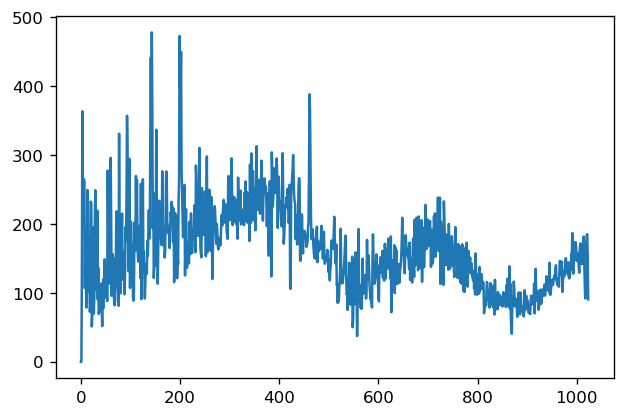

In [4]:
plt.plot(skylines[50])

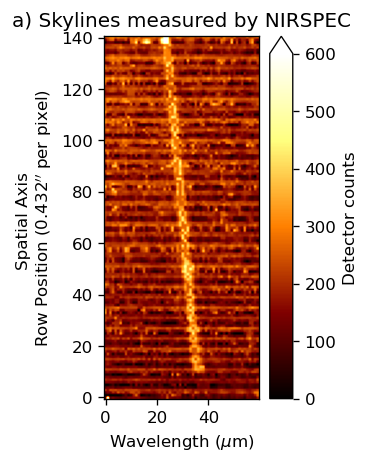

In [9]:
a = np.delete(skylines, np.s_[170:], 1)
b = np.delete(a, np.s_[:110], 1)

plt.figure()
plt.imshow(b, cmap='afmhot')
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel('Spatial Axis \nRow Position (0.432$^{\prime\prime}$ per pixel)')
plt.title('a) Skylines measured by NIRSPEC')
plt.gca().invert_yaxis()
plt.colorbar(extend='max', aspect=15, pad=0.02, label='Detector counts')

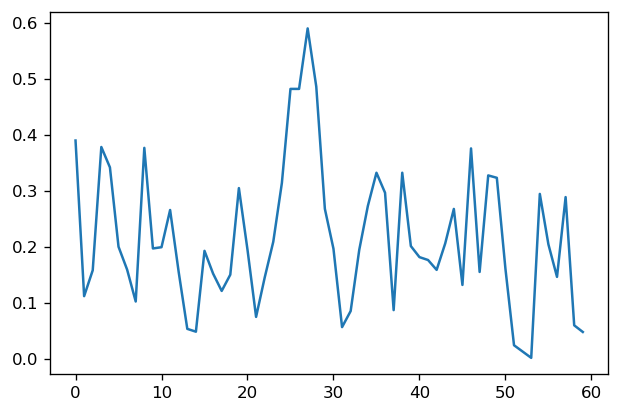

In [41]:
plt.plot(normalize(b)[110])

In [26]:
np.linspace(0 ,np.size(b,1)-1, np.size(b,1))

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59.])

Error occured at i=118
Error occured at i=120
Error occured at i=124


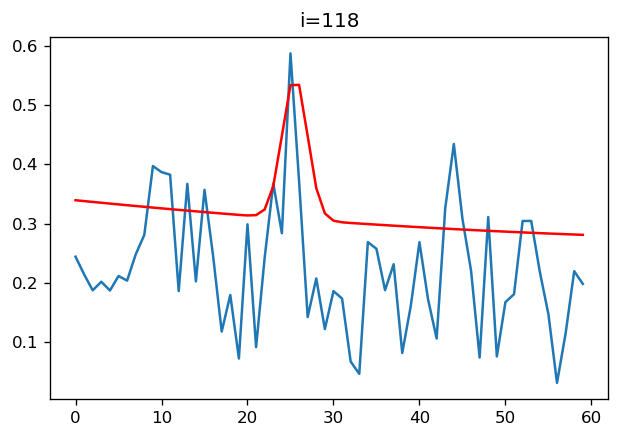

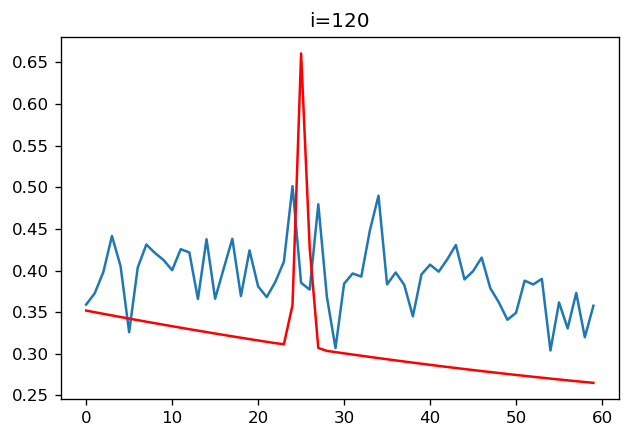

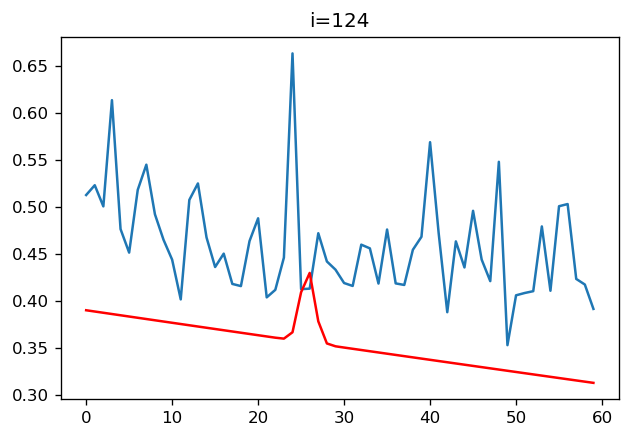

In [45]:
a = np.delete(skylines, np.s_[170:], 1)
b = np.delete(a, np.s_[:110], 1)

b = normalize(b)
waveaxis = np.linspace(0 ,np.size(b,1)-1, np.size(b,1))
# waveaxis = waverange[110:170]*100000

upper_skyline = 141
lower_skyline = 11

sky1_a1 = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):
    if i >= 130 and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.7)
        sky1_params.add('a1', value=23)
        sky1_params.add('a2', value=1)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(b[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
        
    if i >= 110 and i < 130:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.7)
        sky1_params.add('a1', value=27)
        sky1_params.add('a2', value=1)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(b[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
        
    if i >= 90 and i < 110:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.7)
        sky1_params.add('a1', value=27)
        sky1_params.add('a2', value=1)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(b[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
        
    if i >= 70 and i < 90:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.7)
        sky1_params.add('a1', value=29)
        sky1_params.add('a2', value=1)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(b[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
            
    if i >= 50 and i < 70:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.7)
        sky1_params.add('a1', value=31)
        sky1_params.add('a2', value=2)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(b[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
        
    if i >= 30 and i < 50:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.7)
        sky1_params.add('a1', value=32)
        sky1_params.add('a2', value=2)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(b[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
            
    if i >= lower_skyline and i < 30:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.7)
        sky1_params.add('a1', value=33)
        sky1_params.add('a2', value=2)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(b[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
sky1_a1 = sky1_a1+110

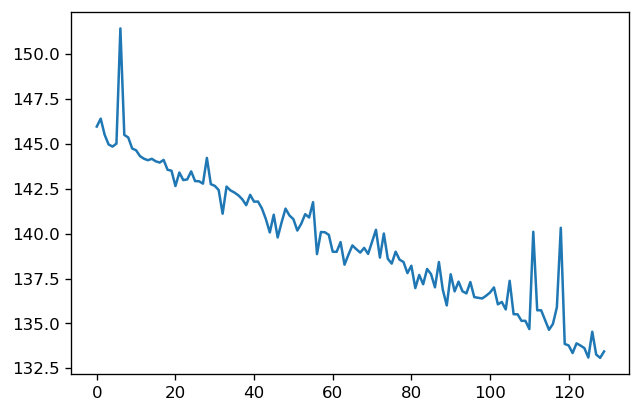

In [46]:
plt.plot(sky1_a1)

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 130
    # variables        = 2
    chi-square         = 140.754314
    reduced chi-square = 1.09964308
    Akaike info crit   = 14.3325904
    Bayesian info crit = 20.0676593
[[Variables]]
    slope:     -0.09080430 +/- 0.00243198 (2.68%) (init = -0.0908043)
    intercept:  166.463336 +/- 0.72571867 (0.44%) (init = 166.4633)
[[Correlations]] (unreported correlations are < 0.250)
    C(slope, intercept) = -0.992


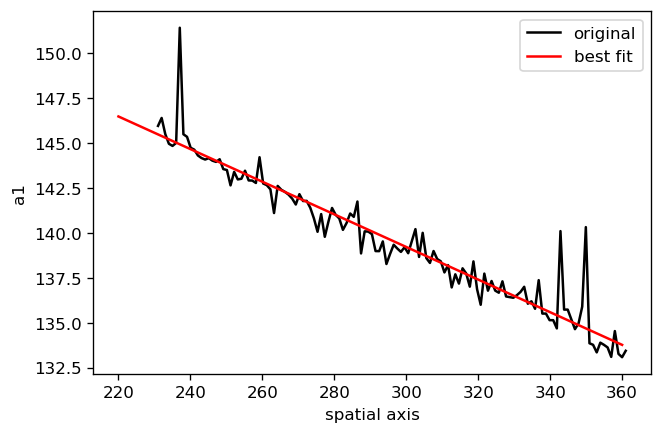

In [57]:
sky1_spat = np.linspace(lower_skyline, upper_skyline, len(sky1_a1))+220

x = sky1_spat
y = sky1_a1

mod = LinearModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

slope = out.params['slope'].value
intercept = out.params['intercept'].value

sky1_spat_all = np.linspace(220, 360, 141)
sky1_a1_best_fit = slope*sky1_spat_all + intercept

plt.figure()
plt.plot(sky1_spat, sky1_a1,'k', label = 'original')
plt.plot(sky1_spat_all, sky1_a1_best_fit, 'r', label = 'best fit')
plt.xlabel('spatial axis')
plt.ylabel('a1')
plt.ticklabel_format(useOffset=False)
plt.legend()

In [60]:
sky1_a1_best_fit

array([146.4863902 , 146.3955859 , 146.3047816 , 146.21397731,
       146.12317301, 146.03236871, 145.94156441, 145.85076012,
       145.75995582, 145.66915152, 145.57834722, 145.48754293,
       145.39673863, 145.30593433, 145.21513003, 145.12432574,
       145.03352144, 144.94271714, 144.85191284, 144.76110855,
       144.67030425, 144.57949995, 144.48869565, 144.39789136,
       144.30708706, 144.21628276, 144.12547846, 144.03467417,
       143.94386987, 143.85306557, 143.76226127, 143.67145698,
       143.58065268, 143.48984838, 143.39904408, 143.30823979,
       143.21743549, 143.12663119, 143.03582689, 142.9450226 ,
       142.8542183 , 142.763414  , 142.6726097 , 142.58180541,
       142.49100111, 142.40019681, 142.30939251, 142.21858822,
       142.12778392, 142.03697962, 141.94617532, 141.85537102,
       141.76456673, 141.67376243, 141.58295813, 141.49215383,
       141.40134954, 141.31054524, 141.21974094, 141.12893664,
       141.03813235, 140.94732805, 140.85652375, 140.76

In [62]:
sky1_pixel_offset_order36 = 138.90636616417416 - sky1_a1_best_fit
# np.savetxt('sky1_pixel_offset_order36.txt', sky1_pixel_offset_order36)
sky1_pixel_offset_order36

array([-7.58002403, -7.48921974, -7.39841544, -7.30761114, -7.21680684,
       -7.12600255, -7.03519825, -6.94439395, -6.85358965, -6.76278536,
       -6.67198106, -6.58117676, -6.49037246, -6.39956817, -6.30876387,
       -6.21795957, -6.12715527, -6.03635098, -5.94554668, -5.85474238,
       -5.76393808, -5.67313379, -5.58232949, -5.49152519, -5.40072089,
       -5.3099166 , -5.2191123 , -5.128308  , -5.0375037 , -4.94669941,
       -4.85589511, -4.76509081, -4.67428651, -4.58348222, -4.49267792,
       -4.40187362, -4.31106932, -4.22026503, -4.12946073, -4.03865643,
       -3.94785213, -3.85704784, -3.76624354, -3.67543924, -3.58463494,
       -3.49383065, -3.40302635, -3.31222205, -3.22141775, -3.13061346,
       -3.03980916, -2.94900486, -2.85820056, -2.76739627, -2.67659197,
       -2.58578767, -2.49498337, -2.40417908, -2.31337478, -2.22257048,
       -2.13176618, -2.04096189, -1.95015759, -1.85935329, -1.76854899,
       -1.6777447 , -1.5869404 , -1.4961361 , -1.4053318 , -1.31